## Installing Trefide

#### Getting Started

##### Prerequisites
* [Anaconda](https://docs.anaconda.com/anaconda/install/) or  
  [Miniconda](https://docs.conda.io/projects/continuumio-conda/en/latest/user-guide/install/)  
* Linux (tested on Ubuntu 18.04, Ubuntu 20.04, Manjaro)

1. **Clone the repository**  

   ```bash
   git clone git@github.com:ikinsella/trefide.git
    ```

2. **Enter the repo**

   ```bash
   cd ~/trefide
   ```

3. **Replace the old YAML**

   Overwrite `environments/devel.yml` with the version shown below.

4. **Create the Conda environment**

   ```bash
   conda env create -f environments/devel.yml
   ```

5. **Activate it**

   ```bash
   conda activate trefide_devel
   ```

6. **Compile the C++ core**

   ```bash
   make all -j $(nproc)
   ```

7. **Build and install the Python package**

   ```bash
   pip install .
   ```

---

#### `environments/devel.yml`

```yaml
name: trefide_devel
channels:
  - defaults
  - conda-forge
dependencies:
  - python=3.9.16=h7a1cb2a_2
  - numpy=1.23.5=py39h14f4228_0
  - cython=0.29.33=py39h6a678d5_0
  - mkl=2021.4.0=h06a4308_640
  - mkl-devel=2021.4.0=h66538d2_640
  - mkl-include=2021.4.0=h06a4308_640
  - mkl-service=2.4.0=py39h7f8727e_0
  - mkl_fft=1.3.1=py39hd3c417c_0
  - mkl_random=1.2.2=py39h51133e4_0
  - intel-openmp=2021.4.0=h06a4308_3561
  - blas=1.0=mkl
  - scikit-learn=1.2.2=py39h6a678d5_1
  - scipy=1.10.1=py39h14f4228_0
  - matplotlib=3.7.1=py39h06a4308_1
  - h5py=3.7.0=py39h737f45e_0
  - jupyter=1.0.0=py39h06a4308_8
  - ipykernel=6.19.2=py39hb070fc8_0
  - tifffile=2021.4.8=pyhd8ed1ab_0
  - imageio=2.27.0=pyh24c5eb1_0
  - pandas=1.5.3=py39h417a72b_0
  - pysimplegui=4.60.4=pyhd8ed1ab_0
  - pip=23.0.1=py39h06a4308_0
  - pip:
      - opencv-python==4.7.0.72
      - emd-signal==1.5.2
      - xlsxwriter==3.1.9
```

> **Note:** The Intel channel (`intel`) has been deprecated. This configuration uses MKL packages from the `defaults` and `conda-forge` channels with specific versions that are known to work together.

---

#### References

```bibtex
@article {Buchanan334706,
    author = {Buchanan, E. Kelly and Kinsella, Ian and Zhou, Ding and Zhu, Rong and Zhou, Pengcheng and Gerhard, Felipe and Ferrante, John and Ma, Ying and Kim, Sharon and Shaik, Mohammed and Liang, Yajie and Lu, Rongwen and Reimer, Jacob and Fahey, Paul and Muhammad, Taliah and Dempsey, Graham and Hillman, Elizabeth and Ji, Na and Tolias, Andreas and Paninski, Liam},
    title = {Penalized matrix decomposition for denoising, compression, and improved demixing of functional imaging data},
    elocation-id = {334706},
    year = {2019},
    doi = {10.1101/334706},
    publisher = {Cold Spring Harbor Laboratory},
    URL = {https://www.biorxiv.org/content/early/2019/01/21/334706},
    eprint = {https://www.biorxiv.org/content/early/2019/01/21/334706.full.pdf},
    journal = {bioRxiv}
}
```


# SAN Trefide Ca Signal Extraction

## Load Data

In [ ]:
!pip install tifffile
!pip install matplotlib

In [2]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [3]:
# Increase the embed limit if needed (in MB)
import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 250

In [4]:
# Load the video from a hard-coded TIFF path with ImageJ-style normalization
# Hard-coded input path
INPUT_TIF = "/home/maltsevav/Documents/Trefide/SAN_DATA/Ca4--10x--.tif"
# Read as (frames, height, width)
raw_video = tifffile.imread(INPUT_TIF)  

# ImageJ-style normalization parameters
SATURATED_PIXELS_PCT = 0.35  # Percentage of pixels to saturate
USE_STACK_HISTOGRAM = True   # Use histogram of entire stack vs per-frame

if USE_STACK_HISTOGRAM:
    # Calculate histogram for the entire stack
    # Flatten all frames into a single array for percentile calculation
    all_pixels = raw_video.flatten()
    
    # Calculate the percentiles based on saturated pixels percentage
    # ImageJ saturates both low and high ends
    lower_percentile = SATURATED_PIXELS_PCT
    upper_percentile = 100.0 - SATURATED_PIXELS_PCT
    
    # Get the actual pixel values at these percentiles
    lower_bound = np.percentile(all_pixels, lower_percentile)
    upper_bound = np.percentile(all_pixels, upper_percentile)
    
    print(f"Stack histogram bounds: {lower_bound:.2f} to {upper_bound:.2f}")
    
    # Apply normalization to entire stack
    # Clip to bounds
    raw_video = np.clip(raw_video, lower_bound, upper_bound)
    
    # Normalize to 0-255 range
    if upper_bound > lower_bound:
        raw_video = ((raw_video - lower_bound) * 255.0 / (upper_bound - lower_bound))
        raw_video = np.round(raw_video).astype(np.uint8)
    else:
        raw_video = np.zeros_like(raw_video, dtype=np.uint8)
else:
    # Process each frame independently (if USE_STACK_HISTOGRAM was False)
    normalized_frames = []
    for frame in raw_video:
        lower_bound = np.percentile(frame, SATURATED_PIXELS_PCT)
        upper_bound = np.percentile(frame, 100.0 - SATURATED_PIXELS_PCT)
        
        # Clip and normalize frame
        frame_clipped = np.clip(frame, lower_bound, upper_bound)
        if upper_bound > lower_bound:
            frame_norm = ((frame_clipped - lower_bound) * 255.0 / (upper_bound - lower_bound))
            frame_norm = np.round(frame_norm).astype(np.uint8)
        else:
            frame_norm = np.zeros_like(frame, dtype=np.uint8)
        
        normalized_frames.append(frame_norm)
    
    raw_video = np.array(normalized_frames)

# Convert to the required format
mov = np.ascontiguousarray(np.moveaxis(raw_video, 0, 2), dtype=np.float32)
H, W, T = mov.shape
print(f"Loaded video: height={H}, width={W}, frames={T}")
print(f"Data range after normalization: {mov.min():.2f} to {mov.max():.2f}")

Stack histogram bounds: 87.00 to 891.00
Loaded video: height=301, width=2060, frames=1727
Data range after normalization: 0.00 to 255.00


Showing middle slice (frame 863) out of 1727 total frames.


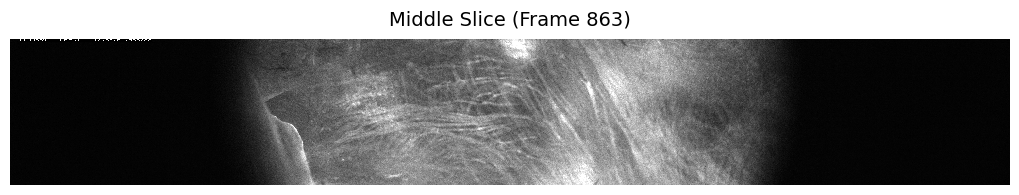

In [5]:
# Find the index of the middle frame using the correct variable 'T'
middle_frame_idx = T // 2

# Extract the middle slice
middle_slice = mov[:, :, middle_frame_idx]

print(f"Showing middle slice (frame {middle_frame_idx}) out of {T} total frames.")

# --- Figure Setup ---
fig_w = 10
fig_h = fig_w * (H / W)
fig, ax = plt.subplots(figsize=(fig_w, fig_h))
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
ax.axis('off')

# Display the static image
ax.imshow(
    middle_slice,
    cmap='gray',
    interpolation='nearest'
)

ax.set_title(f'Middle Slice (Frame {middle_frame_idx})', fontsize=14, pad=10)
plt.show()

In [ ]:
# Inline playback of raw video data with no whitespace borders

# ▶︎ Frame selection flag
show_all_frames = False   # True to show every frame, False to cap at num_frames_to_show
num_frames_to_show = 100  # when show_all_frames is False

# 'mov' is your raw array of shape (H, W, T)
_, _, T_total = mov.shape
if show_all_frames:
    frames_to_use = T_total
    data_to_show = mov.transpose(2, 0, 1)  # (T, H, W)
else:
    frames_to_use = min(num_frames_to_show, T_total)
    data_to_show = mov[:, :, :frames_to_use].transpose(2, 0, 1)

print(f"Showing {frames_to_use} out of {T_total} total frames")

# Compute scaling bounds from the raw data
vmin, vmax = data_to_show.min(), data_to_show.max()

# Figure setup: maintain aspect ratio, remove all margins
T, H, W = data_to_show.shape
fig_w = 10
fig_h = fig_w * (H / W)
fig, ax = plt.subplots(figsize=(fig_w, fig_h))
ax.axis('off')
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)

# Initial frame draw
im = ax.imshow(
    data_to_show[0],
    cmap='gray',
    vmin=vmin,
    vmax=vmax,
    interpolation='nearest',
    animated=True
)

ax.set_title('Raw Video Playback', fontsize=14, pad=10)

# Update function for animation
def update(frame_idx):
    im.set_array(data_to_show[frame_idx])
    return [im]

# Create and display animation
anim = FuncAnimation(
    fig,
    update,
    frames=frames_to_use,
    interval=100,
    blit=True
)
plt.close(fig)
HTML(anim.to_jshtml())

## Preprocessing

In [7]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [8]:
# Preprocessing block for single raw video
print("Starting video preprocessing...")
print(f"Input video shape: {raw_video.shape}")

n_frames, fov_height, fov_width = raw_video.shape

# Step 1: Calculate minimum and maximum pixel images
print("\n1. Calculating min/max pixel images...")
minimum_pixel_image = raw_video.min(axis=0)
maximum_pixel_image = raw_video.max(axis=0)
print(f"   Min pixel range: [{minimum_pixel_image.min():.2f}, {minimum_pixel_image.max():.2f}]")
print(f"   Max pixel range: [{maximum_pixel_image.min():.2f}, {maximum_pixel_image.max():.2f}]")

# Step 2: Create masked array for low SNR regions
print("\n2. Creating low SNR mask...")
mean_max_pixel_value = maximum_pixel_image.mean()
print(f"   Mean max pixel value: {mean_max_pixel_value:.2f}")

FOV_masked_array = np.ma.masked_less_equal(maximum_pixel_image, mean_max_pixel_value, copy=False)
low_SNR_mask = np.ma.getmask(FOV_masked_array)
print(f"   Low SNR pixels: {low_SNR_mask.sum()} ({100*low_SNR_mask.sum()/(fov_height*fov_width):.1f}%)")

# Step 3: Calculate bounding box using GMM
print("\n3. Finding bounding box with GMM...")
scan_left_to_right = maximum_pixel_image.sum(axis=0)
scan_top_to_bottom = maximum_pixel_image.sum(axis=1)

from sklearn.mixture import GaussianMixture

# Fit GMM for left-right
gm = GaussianMixture(n_components=2)
gm.fit(scan_left_to_right.reshape(-1, 1))
lr_threshold_val = float(gm.means_.mean())
print(f"   Left-right threshold: {lr_threshold_val:.2f}")

# Fit GMM for top-bottom
gm = GaussianMixture(n_components=2)
gm.fit(scan_top_to_bottom.reshape(-1, 1))
tb_threshold_val = float(gm.means_.mean())
print(f"   Top-bottom threshold: {tb_threshold_val:.2f}")

# Find boundaries
scan_left_to_right_bool = scan_left_to_right > lr_threshold_val
scan_top_to_bottom_bool = scan_top_to_bottom > tb_threshold_val

if scan_left_to_right_bool.any():
    bbox_left = int(np.argmax(scan_left_to_right_bool))
    bbox_right = int(len(scan_left_to_right_bool) - np.argmax(scan_left_to_right_bool[::-1]))
else:
    bbox_left = 0
    bbox_right = fov_width
    
if scan_top_to_bottom_bool.any():
    bbox_top = int(np.argmax(scan_top_to_bottom_bool))
    bbox_bottom = int(len(scan_top_to_bottom_bool) - np.argmax(scan_top_to_bottom_bool[::-1]))
else:
    bbox_top = 0
    bbox_bottom = fov_height

bbox_height = bbox_bottom - bbox_top
bbox_width = bbox_right - bbox_left

print(f"   Initial bbox: ({bbox_left}, {bbox_top}) to ({bbox_right}, {bbox_bottom})")
print(f"   Initial bbox size: {bbox_width} x {bbox_height}")

# Adjust bounding box height if too small
if bbox_height <= 350:
    print("   Height <= 350, using full height")
    bbox_top = 0
    bbox_bottom = fov_height
    bbox_height = bbox_bottom

# Step 4: Update low SNR mask with boundary encoding
print("\n4. Updating mask with boundaries...")
low_SNR_mask = low_SNR_mask.astype(np.uint8)
low_SNR_mask[:bbox_top, :] = 2
low_SNR_mask[bbox_bottom:, :] = 2
low_SNR_mask[:, :bbox_left] = 2
low_SNR_mask[:, bbox_right:] = 2

# Count mask values
unique, counts = np.unique(low_SNR_mask, return_counts=True)
mask_stats = dict(zip(unique, counts))
print(f"   Mask statistics: {mask_stats}")

# Create padding dictionary
padding = {
    'top': bbox_top,
    'bottom': fov_height - bbox_bottom,
    'left': bbox_left,
    'right': fov_width - bbox_right
}
print(f"   Padding: {padding}")

# Step 5: Crop video if necessary
if (bbox_left > 0 or bbox_top > 0 or bbox_right < fov_width or bbox_bottom < fov_height):
    print("\n5. Cropping video to bounding box...")
    processed_video = raw_video[:, bbox_top:bbox_bottom, bbox_left:bbox_right].copy()
    maximum_pixel_image = maximum_pixel_image[bbox_top:bbox_bottom, bbox_left:bbox_right]
    low_SNR_mask = low_SNR_mask[bbox_top:bbox_bottom, bbox_left:bbox_right]
    print(f"   Cropped shape: {processed_video.shape}")
else:
    print("\n5. No cropping needed")
    processed_video = raw_video.copy()

# Step 6: Apply low SNR mask
print("\n6. Applying low SNR mask...")
processed_video = np.ma.array(
    processed_video,
    mask=np.tile(low_SNR_mask, (n_frames, 1, 1))
)
masked_pixels = processed_video.mask.sum()
total_pixels = n_frames * processed_video.shape[1] * processed_video.shape[2]
print(f"   Masked pixels: {masked_pixels} ({100*masked_pixels/total_pixels:.1f}%)")

processed_video = processed_video.filled(fill_value=0)

print("\n✓ Preprocessing complete!")
print(f"Final video shape: {processed_video.shape}")
print(f"Memory usage: {processed_video.nbytes / 1024**2:.1f} MB")

Starting video preprocessing...
Input video shape: (1727, 301, 2060)

1. Calculating min/max pixel images...
   Min pixel range: [0.00, 255.00]
   Max pixel range: [0.00, 255.00]

2. Creating low SNR mask...
   Mean max pixel value: 91.66
   Low SNR pixels: 324254 (52.3%)

3. Finding bounding box with GMM...
   Left-right threshold: 24183.30
   Top-bottom threshold: 180752.67
   Initial bbox: (515, 0) to (1539, 301)
   Initial bbox size: 1024 x 301
   Height <= 350, using full height

4. Updating mask with boundaries...
   Mask statistics: {0: 294191, 1: 14033, 2: 311836}
   Padding: {'top': 0, 'bottom': 0, 'left': 515, 'right': 521}

5. Cropping video to bounding box...
   Cropped shape: (1727, 301, 1024)

6. Applying low SNR mask...
   Masked pixels: 24234991 (4.6%)

✓ Preprocessing complete!
Final video shape: (1727, 301, 1024)
Memory usage: 507.6 MB


In [9]:
# Modify video for Trefide with symmetric padding
print("\n" + "="*50)
print("Preparing video for Trefide...")

# Transpose to (H, W, T) format
print(f"\n1. Transposing from (T, H, W) to (H, W, T)...")
print(f"   Before: {processed_video.shape}")
mov = np.moveaxis(processed_video, 0, 2)
print(f"   After: {mov.shape}")

old_height, old_width, old_n_frames = mov.shape
block_height = 40
block_width = 40

# Step 1: Ensure even number of frames
if old_n_frames % 2 == 1:
    print(f"\n2. Odd number of frames ({old_n_frames}), removing last frame")
    mov = mov[:, :, :-1]
    new_n_frames = mov.shape[2]
    print(f"   New frame count: {new_n_frames}")
else:
    print(f"\n2. Even number of frames ({old_n_frames}), no change needed")

# Step 2: Calculate padding needed
print(f"\n3. Calculating padding for block size {block_height}x{block_width}...")
vertical_leftover = old_height % block_height
horizontal_leftover = old_width % block_width

vertical_pad_total = (block_height - vertical_leftover) if vertical_leftover else 0
horizontal_pad_total = (block_width - horizontal_leftover) if horizontal_leftover else 0

# Distribute padding evenly
vertical_pad_top = vertical_pad_total // 2
vertical_pad_bottom = vertical_pad_total - vertical_pad_top
horizontal_pad_left = horizontal_pad_total // 2
horizontal_pad_right = horizontal_pad_total - horizontal_pad_left

print(f"   Height {old_height} → pad {vertical_pad_top} top, {vertical_pad_bottom} bottom")
print(f"   Width {old_width} → pad {horizontal_pad_left} left, {horizontal_pad_right} right")

# Step 3: Apply padding if needed
if vertical_pad_total or horizontal_pad_total:
    print(f"\n4. Applying symmetric padding and converting to float64...")
    print(f"   Original dtype: {mov.dtype}")
    mov = np.pad(
        mov,
        pad_width=((vertical_pad_top, vertical_pad_bottom), 
                   (horizontal_pad_left, horizontal_pad_right), 
                   (0, 0))
    ).astype(np.float64)
    print(f"   Padded shape: {mov.shape}")
    print(f"   New dtype: {mov.dtype}")
else:
    print(f"\n4. No padding needed")
    print(f"   Note: dtype remains {mov.dtype}")

# Final stats
H, W, T = mov.shape
print(f"\n✓ Ready for Trefide!")
print(f"Final shape: (H={H}, W={W}, T={T})")
print(f"Final dtype: {mov.dtype}")
print(f"Block grid: {H//block_height} x {W//block_width} blocks")
print(f"Memory usage: {mov.nbytes / 1024**2:.1f} MB")


Preparing video for Trefide...

1. Transposing from (T, H, W) to (H, W, T)...
   Before: (1727, 301, 1024)
   After: (301, 1024, 1727)

2. Odd number of frames (1727), removing last frame
   New frame count: 1726

3. Calculating padding for block size 40x40...
   Height 301 → pad 9 top, 10 bottom
   Width 1024 → pad 8 left, 8 right

4. Applying symmetric padding and converting to float64...
   Original dtype: uint8
   Padded shape: (320, 1040, 1726)
   New dtype: float64

✓ Ready for Trefide!
Final shape: (H=320, W=1040, T=1726)
Final dtype: float64
Block grid: 8 x 26 blocks
Memory usage: 4382.4 MB


Showing middle slice (frame 863) out of 1726 total frames.
Slice shape: (320, 1040)
Value range: [0.00, 255.00]


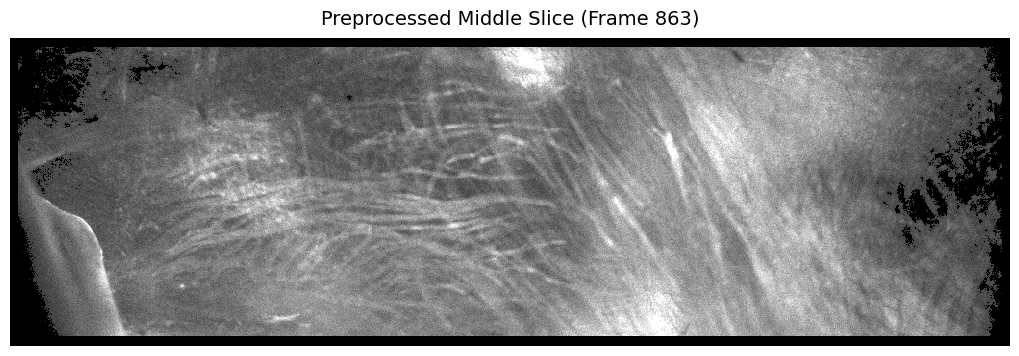

In [10]:
# Get dimensions from preprocessed mov array
H, W, T = mov.shape

# Find the index of the middle frame
middle_frame_idx = T // 2

# Extract the middle slice
middle_slice = mov[:, :, middle_frame_idx]

print(f"Showing middle slice (frame {middle_frame_idx}) out of {T} total frames.")
print(f"Slice shape: {middle_slice.shape}")
print(f"Value range: [{middle_slice.min():.2f}, {middle_slice.max():.2f}]")

# Figure Setup
fig_w = 10
fig_h = fig_w * (H / W)
fig, ax = plt.subplots(figsize=(fig_w, fig_h))
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
ax.axis('off')

# Display the static image
im = ax.imshow(
    middle_slice,
    cmap='gray',
    interpolation='nearest'
)

ax.set_title(f'Preprocessed Middle Slice (Frame {middle_frame_idx})', fontsize=14, pad=10)
plt.show()

In [ ]:
# ▶︎ Frame selection flag
show_all_frames = False   # True to show every frame; False to cap at num_frames_to_show
num_frames_to_show = 100  # when show_all_frames is False

# 'mov' is your preprocessed array of shape (H, W, T)
H, W, T_total = mov.shape
if show_all_frames:
    frames_to_use = T_total
    data_to_show = mov.transpose(2, 0, 1)  # → (T, H, W)
else:
    frames_to_use = min(num_frames_to_show, T_total)
    data_to_show = mov[:, :, :frames_to_use].transpose(2, 0, 1)

print(f"Showing {frames_to_use} out of {T_total} total frames")

# Compute display range from the data
vmin, vmax = data_to_show.min(), data_to_show.max()

# Figure setup: preserve aspect ratio, remove all margins
fig_w = 10
fig_h = fig_w * (H / W)
fig, ax = plt.subplots(figsize=(fig_w, fig_h))
ax.axis('off')
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)

# Initial draw
im = ax.imshow(
    data_to_show[0],
    cmap='gray',
    vmin=vmin,
    vmax=vmax,
    interpolation='nearest',
    animated=True
)

ax.set_title('Preprocessed Video Playback', fontsize=14, pad=10)

# Animation update function
def update(frame_idx):
    im.set_array(data_to_show[frame_idx])
    return [im]

# Create animation
anim = FuncAnimation(
    fig,
    update,
    frames=frames_to_use,
    interval=100,
    blit=True
)
plt.close(fig)

# Display inline
HTML(anim.to_jshtml())

## Trefide

In [12]:
# Block 2: Import Trefide and plotting utilities, set PMD hyperparameters
from trefide.pmd import (
    determine_thresholds,
    overlapping_batch_decompose,
    overlapping_batch_recompose
)
from trefide.reformat import overlapping_component_reformat
from trefide.plot import pixelwise_ranks
from trefide.extras.util_plot import comparison_plot

In [13]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [14]:
# PMD parameters
block_height = block_width = 40
max_components   = 50
max_iters_main   = 10
max_iters_init   = 40
consec_failures  = 3
tol              = 0.0005
d_sub, t_sub     = 2, 2
enable_spatial_denoiser  = True
enable_temporal_denoiser = True
overlapping               = True

In [15]:
spatial_thresh, temporal_thresh = determine_thresholds(
    (H, W, T),               # 1) volume shape
    (block_height, block_width),  # 2) tile size
    consec_failures,         # 3) max consecutive failures
    max_iters_main,          # 4) main-loop max iterations
    max_iters_init,          # 5) init-loop max iterations
    tol,                     # 6) tolerance
    d_sub,                   # 7) spatial decimation
    t_sub,                   # 8) temporal decimation
    5,                       # 9) number of noise trials
    False                    # 10) verbose flag
)
print(f"Thresholds → spatial: {spatial_thresh:.4f}, temporal: {temporal_thresh:.4f}")

Thresholds → spatial: 1.1189, temporal: 1.5540


In [ ]:
# Decompose into low-rank spatial & temporal components (overlapping tiling)
spatial_components, temporal_components, block_ranks, block_indices, block_weights = \
    overlapping_batch_decompose(
        H, W, T,
        mov,
        block_height, block_width,
        spatial_thresh, temporal_thresh,
        max_components,
        consec_failures,
        max_iters_main, max_iters_init, tol,
        d_sub, t_sub
    )
print("Decomposition complete.")

In [17]:
# Recompose the denoised video with background subtraction
mov_denoised = overlapping_batch_recompose(
    H, W, T,
    block_height, block_width,
    spatial_components, temporal_components,
    block_ranks, block_indices, block_weights
)
mov_denoised = np.asarray(mov_denoised)

# Move time axis back to first dimension temporarily
mov_denoised = np.moveaxis(mov_denoised, 2, 0)  # (T, H, W)

# Clip to non-negative values
np.clip(mov_denoised, 0, None, out=mov_denoised)

# Subtract per-pixel minimum (background subtraction)
denoised_MIN_FOV = mov_denoised.min(axis=0)
mov_denoised -= denoised_MIN_FOV

# Check maximum value and convert data type
denoised_MAX_FOV = mov_denoised.max(axis=0)
max_maximum = denoised_MAX_FOV.max()

if max_maximum > 255:
    mov_denoised = mov_denoised.round().astype(np.uint16)
    print("Converted denoised output to uint16")
else:
    mov_denoised = mov_denoised.round().astype(np.uint8)
    print("Converted denoised output to uint8")

# Move time axis back to last dimension for consistency
mov_denoised = np.moveaxis(mov_denoised, 0, 2)  # Back to (H, W, T)

print("Recomposition complete with background subtraction.")

Converted denoised output to uint8
Recomposition complete with background subtraction.


Showing middle slice (frame 863) out of 1726 total frames.


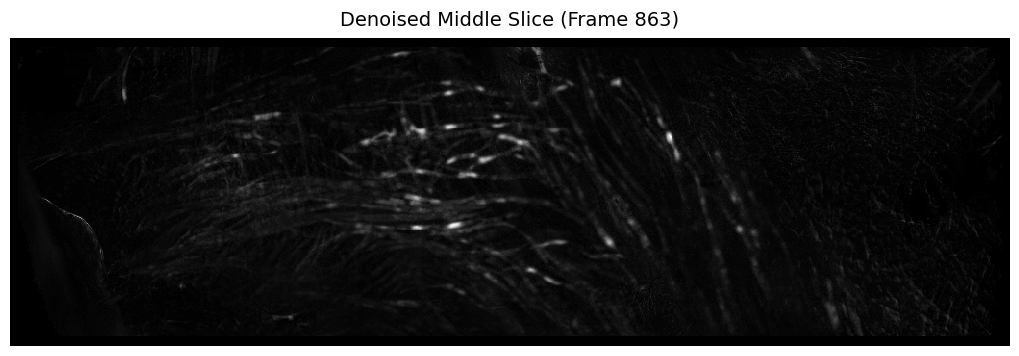

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Find the index of the middle frame
middle_frame_idx = T_total // 2

# Extract the middle slice, which is a 2D array of shape (H, W)
middle_slice = mov_denoised[:, :, middle_frame_idx]

print(f"Showing middle slice (frame {middle_frame_idx}) out of {T_total} total frames.")

# Maintain aspect ratio, remove all margins
fig_w = 10
fig_h = fig_w * (H / W)
fig, ax = plt.subplots(figsize=(fig_w, fig_h))
fig.subplots_adjust(left=0, right=1, top=1, bottom=0) # Remove whitespace borders
ax.axis('off')

# Display the static image of the denoised middle slice
ax.imshow(
    middle_slice,
    cmap='gray',
    interpolation='nearest'
)

ax.set_title(f'Denoised Middle Slice (Frame {middle_frame_idx})', fontsize=14, pad=10)

# Show the plot
plt.show()

In [ ]:
# ▶︎ Frame selection flag
show_all_frames = False   # True to show every frame; False to cap at num_frames_to_show
num_frames_to_show = 100  # when show_all_frames is False

# 'mov_denoised' is your denoised array of shape (H, W, T)
H, W, T_total = mov_denoised.shape
if show_all_frames:
    frames_to_use = T_total
    data_to_show = mov_denoised.transpose(2, 0, 1)  # → (T, H, W)
else:
    frames_to_use = min(num_frames_to_show, T_total)
    data_to_show = mov_denoised[:, :, :frames_to_use].transpose(2, 0, 1)

print(f"Showing {frames_to_use} out of {T_total} total frames of denoised video")

# Compute display range from the denoised data
vmin, vmax = data_to_show.min(), data_to_show.max()

# Figure setup: preserve aspect ratio, remove all margins
fig_w = 10
fig_h = fig_w * (H / W)
fig, ax = plt.subplots(figsize=(fig_w, fig_h))
ax.axis('off')
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)

# Initial draw
im = ax.imshow(
    data_to_show[0],
    cmap='gray',
    vmin=vmin,
    vmax=vmax,
    interpolation='nearest',
    animated=True
)

ax.set_title('Denoised Video Playback', fontsize=14, pad=10)

# Animation update function
def update_denoised(frame_idx):
    im.set_array(data_to_show[frame_idx])
    return [im]

# Create animation
anim = FuncAnimation(
    fig,
    update_denoised,
    frames=frames_to_use,
    interval=100,
    blit=True
)
plt.close(fig)

# Display inline
HTML(anim.to_jshtml())

In [22]:
# Save the denoised video back to a TIFF stack
# Move time axis back to front: (T, H, W)

import os
out_dir = "./results"
os.makedirs(out_dir, exist_ok=True)
file_output_name = 'SAN_trefide.tif'

denoised_stack = np.moveaxis(mov_denoised, 2, 0)
tifffile.imwrite(
    os.path.join(out_dir, file_output_name),
    denoised_stack.astype(raw_video.dtype),
    bigtiff=True
)
print(f"Saved denoised video to {file_output_name}")

Saved denoised video to SAN_trefide.tif
